<a href="https://colab.research.google.com/github/eteral00/UNT_CSCE5218_Project_DogsBreeds/blob/main/ResNet50v2_TF_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mounting GoogleDrive**
You will need to add a shortcut to this Google shared folder to your own Google Drive to be able to access the dataset, the saved models, nad saved output statistics: \\
https://drive.google.com/drive/folders/1IypaLVub6Mk9A0AO_hN3wv5yEY04JNin

As well as going through this list of shared folders so that your drive recognized you have access to them (they are allshared as "has-link-can-view", but your GGDrive still need to recognize that you have the access) \\
https://drive.google.com/drive/folders/18QH_EOzL4halbKdHtDBil-De9Ia_Ys1d

https://drive.google.com/drive/folders/1Q2AhR6p28aD6J57ICYipuwvPgCgLoj1t

https://drive.google.com/drive/folders/1O75reXnX9LOT6LusUM1KUN6X8DlDor6S

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **Handling data**

## Dataset: Tsinghua Dogs:
Main link: https://cg.cs.tsinghua.edu.cn/ThuDogs/ \\
Lower resolution version (~2.5GBs): https://cloud.tsinghua.edu.cn/f/80013ef29c5f42728fc8/

## Decompress

In [ ]:
!unzip "/content/drive/MyDrive/CSCE5218/Dog_Breed_classification/Dog_Breed_dataset/Tshihua/low-resolution.zip" -d "/content/"
!unzip "/content/drive/MyDrive/CSCE5218/Dog_Breed_classification/Dog_Breed_dataset/Tshihua/TrainValSplit.zip" -d "/content/"

## Preprocess data

### Import libraries/packages

In [ ]:
import cv2
import numpy as np
import pandas as pd
import shutil
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split




In [ ]:
def read_image(path, size):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (size, size))
    image = image / 255.0
    image = image.astype(np.float32)
    return image


In [ ]:
def parse_data(x, y):
    x = x.decode()

    num_class = 130
    size = 256

    image = read_image(x, size)
    label = [0] * num_class
    label[y] = 1
    label = np.array(label)
    label = label.astype(np.int32)

    return image, label

In [ ]:
def tf_parse(x, y):
    x, y = tf.numpy_function(parse_data, [x, y], [tf.float32, tf.int32])
    x.set_shape((256, 256, 3))
    y.set_shape((130))
    return x, y

In [ ]:
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

## Split to Train/Val (here Val=Test set)

In [ ]:
import argparse
import os
import shutil
import logging
import sys
import glob
from typing import Dict, Any, Set

def split_train_val(images_dir: str, output_dir: str, lst_path: str):
    with open(lst_path, "r") as f:
        lst: Set[str] = set([os.path.basename(line.strip()) for line in f.readlines()])

    for image_name in lst:
        image_path: str = glob.glob(os.path.join(images_dir, "*", image_name), recursive=True)[0]
        class_name: str = os.path.basename(os.path.dirname(image_path))

        dest_dir: str = os.path.join(output_dir, class_name)
        os.makedirs(dest_dir, exist_ok=True)

        logging.info(f"Copying {image_path} to {dest_dir}")
        shutil.copy(image_path, dest_dir)

In [ ]:
## data directory paths
TSINGHUA_DOGS_ROOT_DIR = "/content/drive/MyDrive/CSCE5218/Dog_Breed_classification"
content_root = "/content"
images_dir: str = os.path.join(content_root, "low-resolution")
train_lst_path: str = os.path.join(content_root, "TrainAndValList", "train.lst")
val_lst_path: str = os.path.join(content_root, "TrainAndValList", "validation.lst")


### \* Storing splited sets in GGDrive

In [ ]:
## Only run this once if putting data in shared folder on ggdrive

# #Prepare train set
# train_dir: str = os.path.join(TSINGHUA_DOGS_ROOT_DIR, "train")
# os.makedirs(train_dir, exist_ok=True)
# split_train_val(images_dir, output_dir=train_dir, lst_path=train_lst_path)

# #Prepare validation set
# val_dir: str = os.path.join(TSINGHUA_DOGS_ROOT_DIR, "val")
# os.makedirs(val_dir, exist_ok=True)
# split_train_val(images_dir, output_dir=val_dir, lst_path=val_lst_path)

### \* Storing splited sets in temporary directory of runtime

In [ ]:
##If putting data in temporary runtime directory, need to rerun this every time

##Prepare train set
train_dir: str = os.path.join(content_root, "train")
os.makedirs(train_dir, exist_ok=True)
split_train_val(images_dir, output_dir=train_dir, lst_path=train_lst_path)

##Prepare test set
val_dir: str = os.path.join(content_root, "val")
os.makedirs(val_dir, exist_ok=True)
split_train_val(images_dir, output_dir=val_dir, lst_path=val_lst_path)

In [ ]:
path = "/content"
train_path = os.path.join(path, "train/*")
test_path = os.path.join(path, "val/*")

train_dirs = glob.glob(train_path)
label_names = []
ids = []
for image_dir in train_dirs:
    basename = os.path.basename(image_dir)
    breed_name = basename.split("-")[2]
    for image in glob.glob(image_dir + "/*"):
      ids.append(image)
      label_names.append(breed_name)

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(label_names)
labels = le.transform(label_names)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(ids, labels, test_size=0.2, random_state=42)

# **Defining Neural Network model(s)**

## Define a function to build a ResNet from a pretrained model in library (ResNet50)

In [ ]:

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,GlobalAveragePooling2D,Dense,Flatten,Dropout,AvgPool2D
from tensorflow.keras.layers import BatchNormalization
from keras.constraints import unit_norm
from keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.models import load_model, Model


# function to import a pretrained ResNet from Tensorflow/Keras
def build_model(size, num_classes):
  resnet = ResNet50V2(input_shape = [256,256,3], weights='imagenet', include_top=False)
  #freeze all trainable layers and train only top layers 
  for layer in resnet.layers:
      layer.trainable = False
  
  #add global average pooling layer and Batch Normalization layer
  x = resnet.output
  x = BatchNormalization()(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.2)(x)
  #add fully connected layer
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.2)(x)
  predictions = Dense(num_classes, activation='softmax')(x)
  
  model = Model(inputs=resnet.input, outputs=predictions)
  return model

## Setting up train functions & utilities

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

## Parameters
size = 256
num_classes = 130
lr = 1e-3
batch = 100

## Model
model = build_model(size, num_classes)
#using RMSprop optimizer to compile or build the model
optimizer = RMSprop(learning_rate=lr,rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])
# model.summary()

# path to store model & its checkpoints
# model_store_path = "/content/drive/MyDrive/Dog_Breed_classification/Models/resnet50v2_tsinghua.h5"
model_store_path = "/content/drive/MyDrive/CSCE5218/Dog_Breed_classification/Models/resnet50v2_tsinghua.h5"

# path when storing on runtime temporary directory
# model_store_path = "/content/output/resnet50v2_tsinghua.h5"


## Training
callbacks = [
    ModelCheckpoint(model_store_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)
]
## Dataset
train_dataset = tf_dataset(x_train, y_train, batch=batch)
valid_dataset = tf_dataset(x_test, y_test, batch=batch)

# Training Section
## Calling the train function & logging history for train/validation

In [ ]:
train_steps = (len(x_train)//32) + 1
valid_steps = (len(x_test)//32) + 1
history = model.fit(train_dataset, steps_per_epoch=train_steps, validation_steps=valid_steps, validation_data=valid_dataset,epochs=20, callbacks=callbacks)

Epoch 1/20
1631/1631 [==============================] - ETA: 0s - loss: 0.8319 - accuracy: 0.7478
Epoch 1: val_loss improved from inf to 0.96497, saving model to /content/drive/MyDrive/Dog_Breed_classification/Models/resnet50v2_tsinghua.h5
1631/1631 [==============================] - 948s 573ms/step - loss: 0.8319 - accuracy: 0.7478 - val_loss: 0.9650 - val_accuracy: 0.7412 - lr: 0.0010
Epoch 2/20
1631/1631 [==============================] - ETA: 0s - loss: 0.3602 - accuracy: 0.8810
Epoch 2: val_loss did not improve from 0.96497
1631/1631 [==============================] - 927s 568ms/step - loss: 0.3602 - accuracy: 0.8810 - val_loss: 1.2404 - val_accuracy: 0.7357 - lr: 0.0010
Epoch 3/20
1631/1631 [==============================] - ETA: 0s - loss: 0.2032 - accuracy: 0.9306
Epoch 3: val_loss did not improve from 0.96497
1631/1631 [==============================] - 912s 559ms/step - loss: 0.2032 - accuracy: 0.9306 - val_loss: 1.4955 - val_accuracy: 0.7338 - lr: 0.0010
Epoch 4/20
1631/1631

## Plotting the results

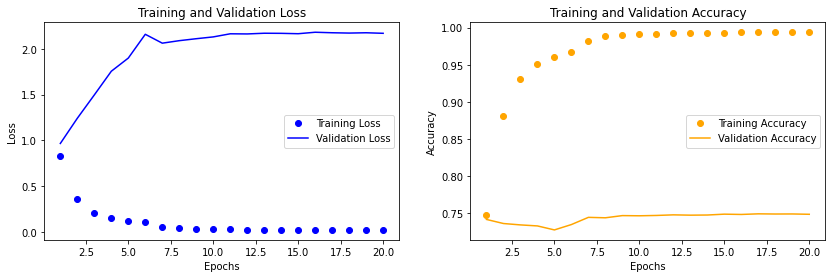

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training Accuracy', c='orange')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy', c='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()